## Setup

In [1]:
import os

from seabass import lmm_hier
from seabass.screen_data import ScreenData 

import torch
import scipy.special
import scipy.stats
import plotnine as p9
import pickle

import matplotlib.pyplot as plt
import sys
import pyro
import pandas as pd
from pathlib import Path
import numpy as np
import datetime 

import statsmodels.stats.multitest # .fdrcorrection(pvals, alpha=0.05, method='indep', is_sorted=False)[source]

from importlib import reload  # Python 3.4+

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if str(device) == "cpu": torch.set_num_threads(20)

p9.themes.theme_set(p9.themes.theme_bw(base_size = 14))

class StopExecution(Exception):
    def _render_traceback_(self):
        return []


/gpfs/commons/home/daknowles/.conda/envs/asb/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
# load data
dat = pd.read_csv("test_data.tsv.gz", sep = "\t")

nt_data = ScreenData.from_pandas(dat[dat["type"]=="NT"] , device = device) 

essential_data = ScreenData.from_pandas(dat[dat["type"]=="essential"] , device = device) 

dat.head()

,junction,sgrna,logFC,type,day,replicate,gene,week
0,NaN,rc_000007,-0.863029,NT,D07,R2,NaN,1
1,NaN,rc_000007,-1.908617,NT,D14,R2,NaN,2
2,NaN,rc_000007,-3.842785,NT,D21,R2,NaN,3
3,NaN,rc_000007,0.140155,NT,D07,R3,NaN,1
4,NaN,rc_000007,0.156591,NT,D14,R3,NaN,2


## Fit model

In [52]:
hierarchical_noise = False
hierarchical_slope = False
t_df = 0.

model, guide, losses, posts, optim_record = lmm_hier.fit_NT_then_other(
    nt_data, 
    essential_data, 
    hierarchical_noise = hierarchical_noise, 
    hierarchical_slope = hierarchical_slope,
    t_df = t_df
)

Optimizing: sigma_noise slope_noise noise_t_df slope_t_df
Stalled after 65 iterations. Increasing num_particles to 2.
Stalled after 25 iterations. Increasing num_particles to 4.
Stalled after 29 iterations. Increasing num_particles to 8.
Stalled after 22 iterations. Increasing num_particles to 16.
Stalled after 20 iterations. Increasing num_particles to 32.
Stalled after 24 iterations. Increasing num_particles to 64.
Optimizing: log_guide_std_mean log_guide_std_std
Stalled after 154 iterations. Increasing num_particles to 2.
Stalled after 61 iterations. Increasing num_particles to 4.
Stalled after 57 iterations. Increasing num_particles to 8.
Stalled after 46 iterations. Increasing num_particles to 16.
Stalled after 74 iterations. Increasing num_particles to 32.
Stalled after 60 iterations. Increasing num_particles to 64.


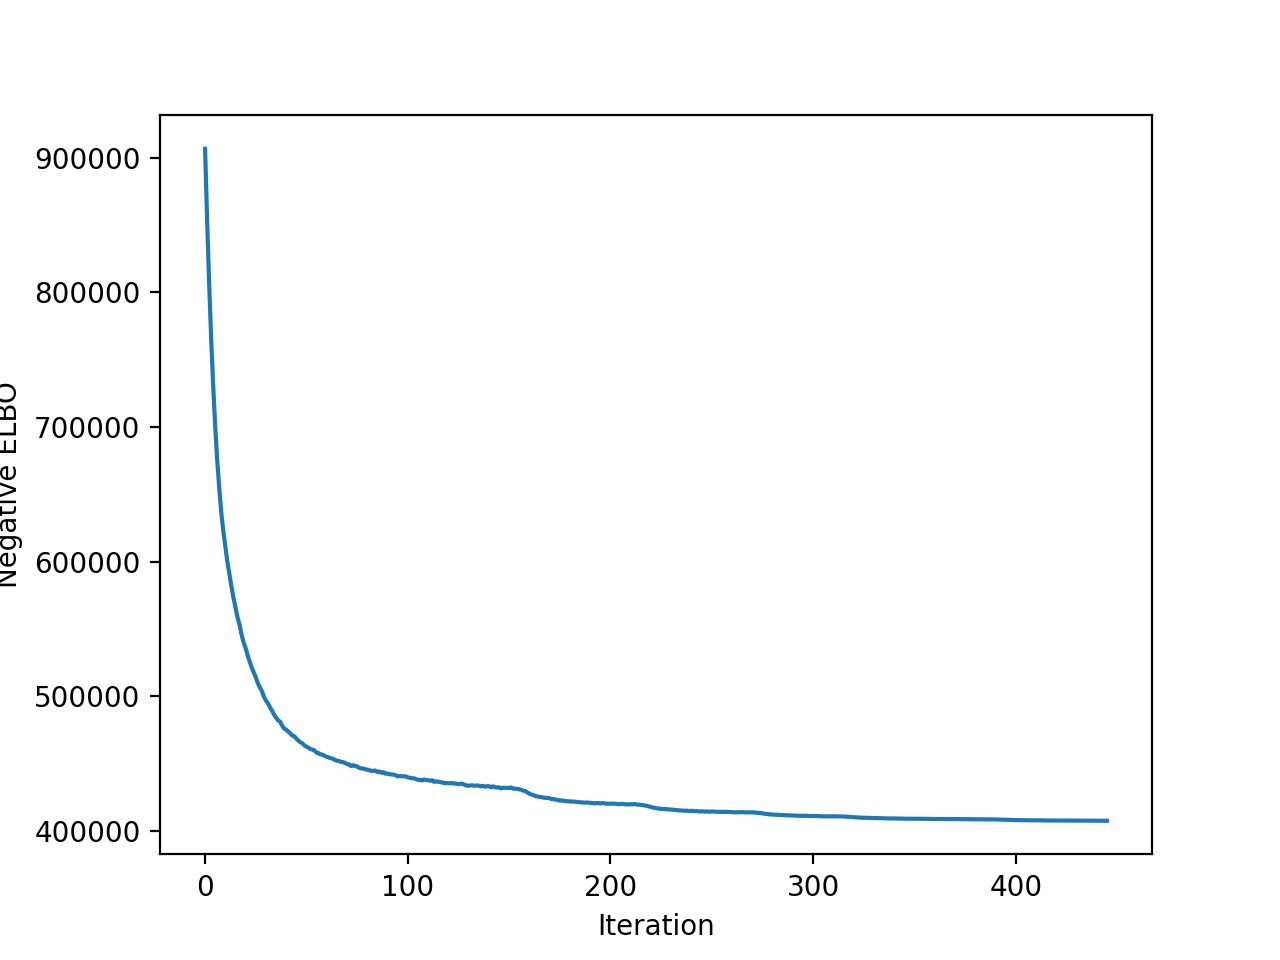

In [54]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Negative ELBO")
plt.show()

## Examine results a little

In [55]:
np.mean(posts["q"] < 0.1) # percent of guides with significant effect at 10% FDR

0.12096446208966787

In [56]:
# save results to file
pd.DataFrame( { 
    "guide" : essential_data.sgrnas,
    "slope" : posts["guide_score"],
    "se" : posts["guide_score_se"],
    "z" : posts["z"],
    "p" : posts["p"],
    "q" : posts["q"] # p adjusted
} ).to_csv("lmm_results.tsv.gz", sep='\t', index=False)

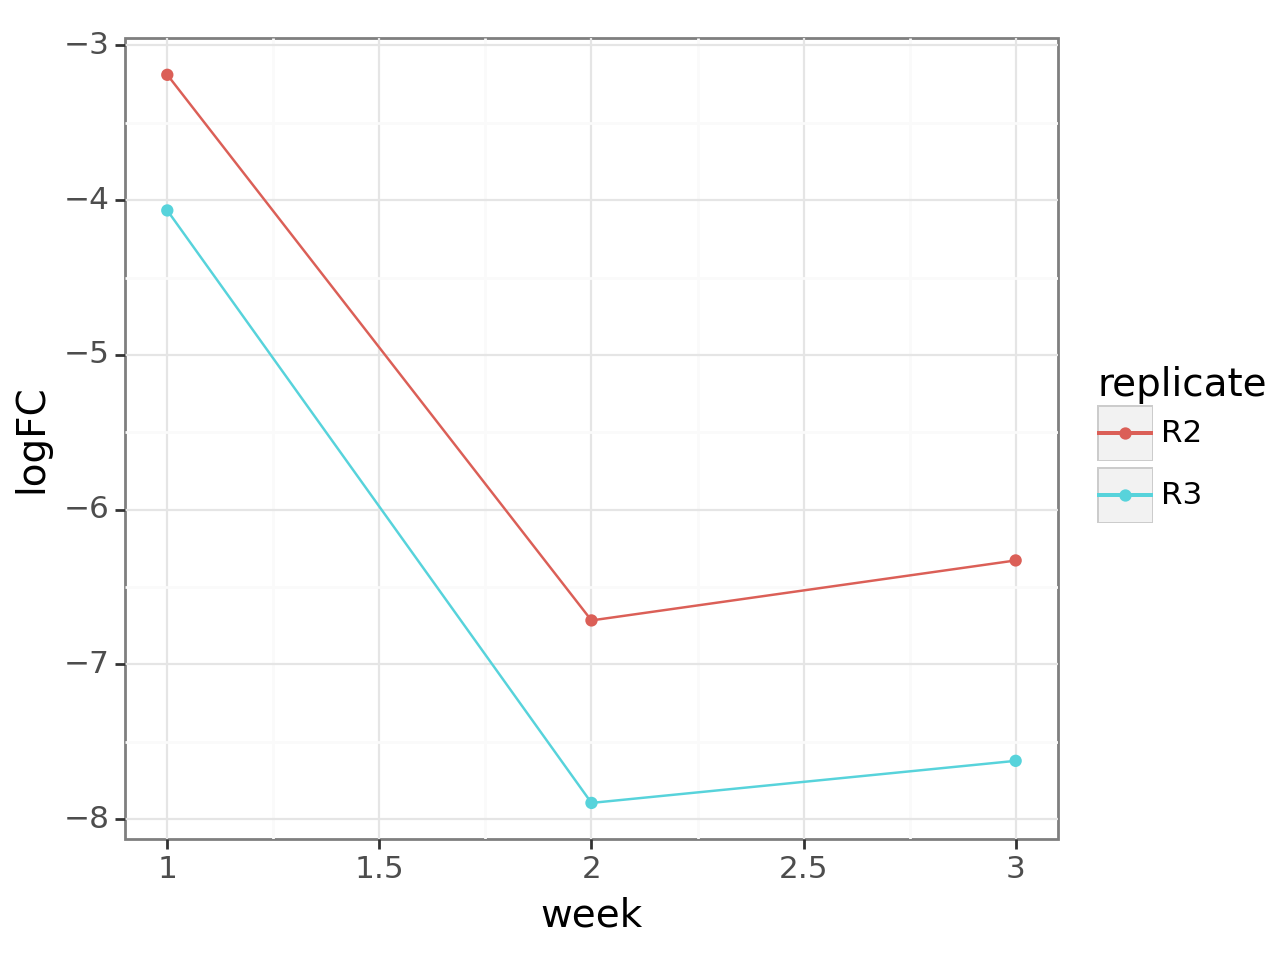

<Figure Size: (640 x 480)>

In [35]:
import plotnine as p9

most_sig_guide = essential_data.sgrnas[posts["guide_score"].argmin()]

p9.ggplot(dat[dat.sgrna == most_sig_guide], p9.aes("week","logFC",color="replicate")) + p9.geom_point() + p9.geom_line()